Welcome to my kernel
Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

This the HAM10000 ("Human Against Machine with 10000 training images") dataset.It consists of 10015 dermatoscopicimages which are released as a training set for academic machine learning purposes and are publiclyavailable through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts.

It has 7 different classes of skin cancer which are listed below :
1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma

# ***Objective :***

   Create an online tool that can tell doctors and lab technologists the three highest probability diagnoses for a given skin lesion.    This will help them quickly identify high priority patients and speed up their workflow. The app should produce a result in less      than 3 seconds. To ensure privacy the images must be pre-processed and analysed locally and never be uploaded to an external          server.

In [1]:
#importing required libraries
from numpy.random import seed
seed(42)

import os
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow
tensorflow.random.set_seed(42)

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

# **LABELS :**

**1. Melanocytic nevi (nv) -**

Melanocytic nevi are benign neoplasms of melanocytes and appear in a myriad of variants, which all are included in our series. The variants may differ significantly from a dermatoscopic point of view.

[6705 images]

**2. Melanoma (mel) -**

Melanoma is a malignant neoplasm derived from melanocytes that may appear in different variants. If excised in an early stage it can be cured by simple surgical excision. Melanomas can be invasive or non-invasive (in situ). We included all variants of melanoma including melanoma in situ, but did exclude non-pigmented, subungual, ocular or mucosal melanoma.

[1113 images]

**3. Benign keratosis-like lesions (bkl) -**

"Benign keratosis" is a generic class that includes seborrheic ker- atoses ("senile wart"), solar lentigo - which can be regarded a flat variant of seborrheic keratosis - and lichen-planus like keratoses (LPLK), which corresponds to a seborrheic keratosis or a solar lentigo with inflammation and regression [22]. The three subgroups may look different dermatoscop- ically, but we grouped them together because they are similar biologically and often reported under the same generic term histopathologically. From a dermatoscopic view, lichen planus-like keratoses are especially challeng- ing because they can show morphologic features mimicking melanoma [23] and are often biopsied or excised for diagnostic reasons.

[1099 images]

**4. Basal cell carcinoma (bcc) -**

Basal cell carcinoma is a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated. It appears in different morphologic variants (flat, nodular, pigmented, cystic, etc) [21], which are all included in this set.

[514 images]

**5. Actinic keratoses (akiec) -**

Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease) are common non-invasive, variants of squamous cell car- cinoma that can be treated locally without surgery. Some authors regard them as precursors of squamous cell carcinomas and not as actual carci- nomas. There is, however, agreement that these lesions may progress to invasive squamous cell carcinoma - which is usually not pigmented. Both neoplasms commonly show surface scaling and commonly are devoid of pigment. Actinic keratoses are more common on the face and Bowen’s disease is more common on other body sites. Because both types are in- duced by UV-light the surrounding skin is usually typified by severe sun damaged except in cases of Bowen’s disease that are caused by human papilloma virus infection and not by UV. Pigmented variants exists for Bowen’s disease [19] and for actinic keratoses [20]. Both are included in this set.

[327 images]

**6. Vascular lesions (vasc) -**

Vascular skin lesions in the dataset range from cherry angiomas to angiokeratomas [25] and pyogenic granulomas [26]. Hemorrhage is also included in this category.

[142 images]

**7. Dermatofibrom (df) -**

Dermatofibroma is a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma. It is brown often showing a central zone of fibrosis dermatoscopically [24].

[115 images]


[Total images = 10015]

# **Create a directory structure :**

In [2]:
#Create a Base Directory
base_dir = 'Base_Directory'
os.mkdir(base_dir)

#creating folders inside Base Directory
train_dir = os.path.join(base_dir, 'Train_Directory')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'Validation_Directory')
os.mkdir(val_dir)

#creating separate folders for each label class in both train and validation directory
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

# Data Exploration

In [3]:
#getting the metadata of the dataset

metadata = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


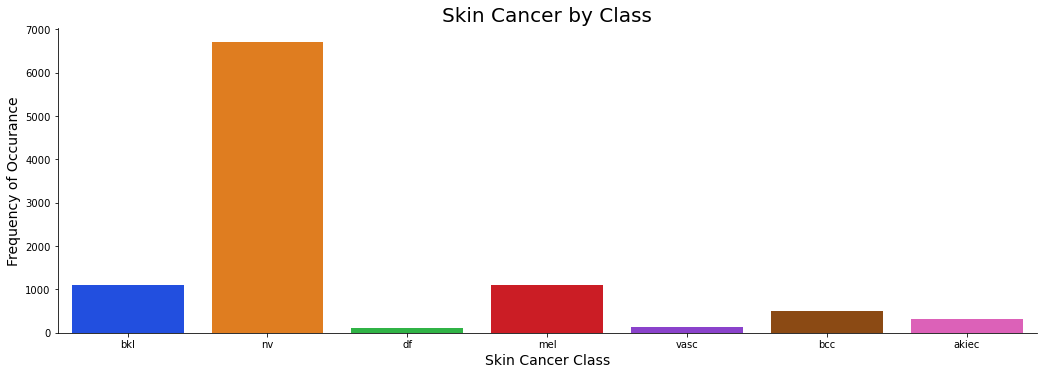

In [4]:
#Skin Cancer by class
g = sns.catplot(x="dx", kind="count", palette='bright', data=metadata)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Class', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)

This graph shows the dataset has a major problem of class imbalance

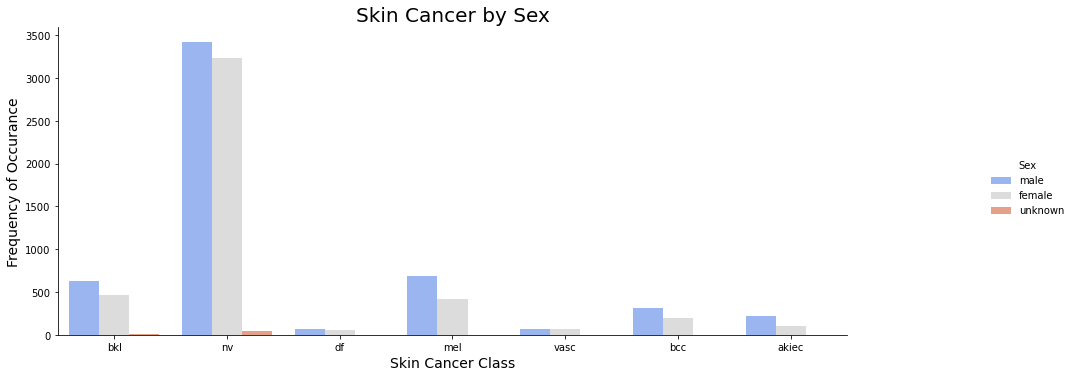

In [5]:
#Skin Cancer by sex
g = sns.catplot(x="dx", kind="count", hue="sex", palette='coolwarm', data=metadata)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Sex', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Sex')

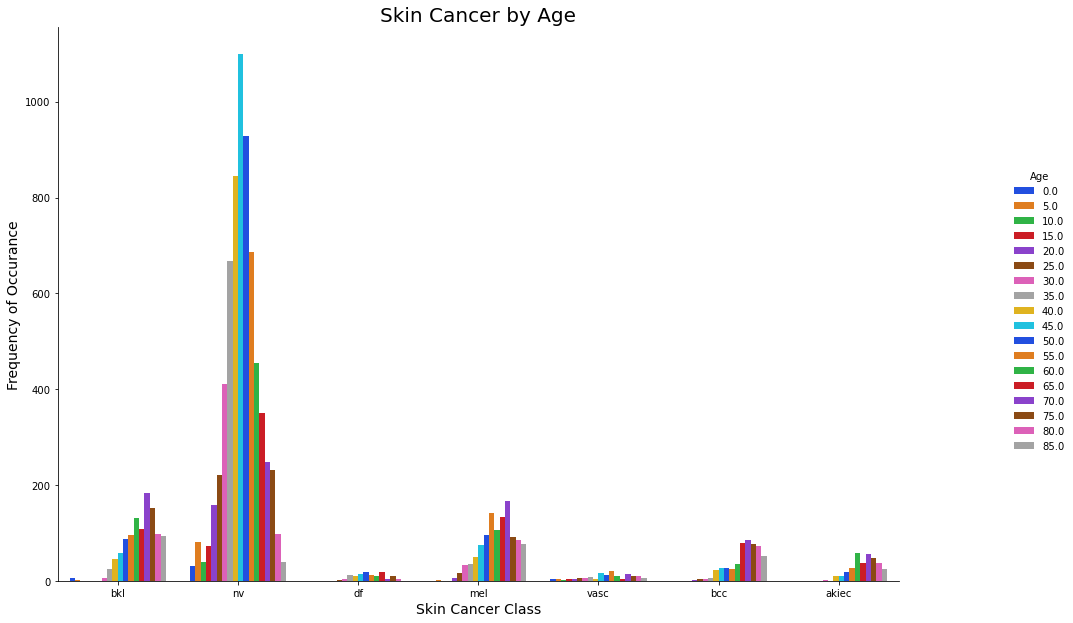

In [6]:
#Skin Cancer by age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Age')

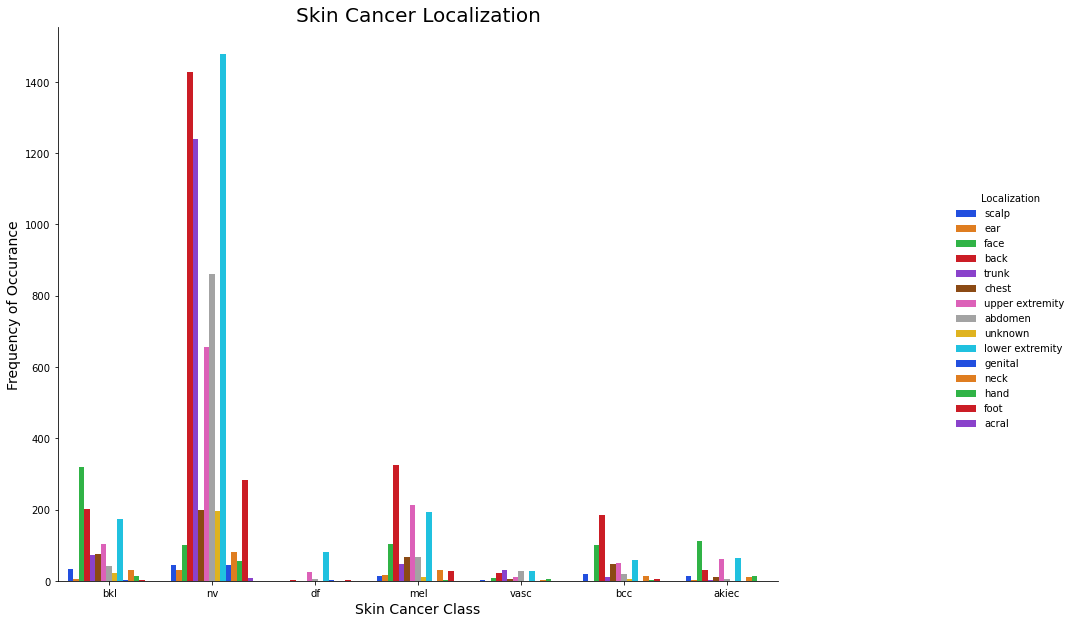

In [7]:
# Skin Cancer occurence body localization
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

# **Splitting data into training and validation sets :**

In [8]:
# this will tell us how many images are associated with each lesion_id
df = metadata.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1
5,HAM_0000010,1,1,1,1,1,1
6,HAM_0000011,1,1,1,1,1,1
7,HAM_0000013,1,1,1,1,1,1
8,HAM_0000015,1,1,1,1,1,1
9,HAM_0000016,1,1,1,1,1,1


In [9]:
# here we identify lesion_id's that have duplicate images and those that have only one image.

def identify_duplicates(x):
    unique_list = list(df['lesion_id'])
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
metadata['duplicates'] = metadata['lesion_id']
# apply the function to this new column
metadata['duplicates'] = metadata['duplicates'].apply(identify_duplicates)

metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,has_duplicates
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,has_duplicates
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,has_duplicates
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,has_duplicates
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,has_duplicates


In [10]:
metadata.duplicates.value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [11]:
#Now we filter out the images that don't have duplicates
df = metadata[metadata.duplicates == 'no_duplicates']
df.shape

(5514, 8)

In [12]:
labels = df['dx']
_, validation_set = train_test_split(df, test_size=0.17, random_state=42, stratify=labels)
validation_set.shape

(938, 8)

In [13]:
#creating a training set that excludes the validation set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(validation_set['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new column that is a copy of the image_id column
metadata['train_or_val'] = metadata['image_id']
# apply the function to this new column
metadata['train_or_val'] = metadata['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
training_set = metadata[metadata['train_or_val'] == 'train']

#Dropping the unwanted columns
training_set.drop(['train_or_val', 'duplicates'], axis=1, inplace=True)
validation_set.drop(['duplicates'], axis=1, inplace=True)

print(training_set.shape)
print(validation_set.shape)

(9077, 7)
(938, 7)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# **Transfer the images into the folders**

In [14]:
#setting image_id as the index of the metadata
metadata.set_index('image_id', inplace=True)

#getting list of images in each of the 2 folders
folder1 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1')
folder2 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2')

#getting list of training and validation images
train_list = list(training_set['image_id'])
val_list = list(validation_set['image_id'])

#transferring the training images
for image in train_list:
    filename = image + '.jpg'
    label = metadata.loc[image, 'dx']
    
    if filename in folder1:
        source = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', filename)
    elif filename in folder2:
        source = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2', filename)
    
    destination = os.path.join(train_dir, label, filename)
    shutil.copyfile(source, destination)   #copy the image from source to destination

#transferring the validation images
for image in val_list:
    filename = image + '.jpg'
    label = metadata.loc[image, 'dx']
    
    if filename in folder1:
        source = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', filename)
    elif filename in folder2:
        source = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2', filename)
    
    destination = os.path.join(val_dir, label, filename)
    shutil.copyfile(source, destination)   #copy the image from source to destination

In [15]:
# check how many train images we have in each folder

print(len(os.listdir('./Base_Directory/Train_Directory/akiec')))
print(len(os.listdir('./Base_Directory/Train_Directory/mel')))
print(len(os.listdir('./Base_Directory/Train_Directory/bcc')))
print(len(os.listdir('./Base_Directory/Train_Directory/bkl')))
print(len(os.listdir('./Base_Directory/Train_Directory/df')))
print(len(os.listdir('./Base_Directory/Train_Directory/nv')))
print(len(os.listdir('./Base_Directory/Train_Directory/vasc')))

301
1074
484
1024
109
5954
131


In [16]:
# check how many val images we have in each folder

print(len(os.listdir('./Base_Directory/Validation_Directory/nv')))
print(len(os.listdir('./Base_Directory/Validation_Directory/mel')))
print(len(os.listdir('./Base_Directory/Validation_Directory/bkl')))
print(len(os.listdir('./Base_Directory/Validation_Directory/bcc')))
print(len(os.listdir('./Base_Directory/Validation_Directory/akiec')))
print(len(os.listdir('./Base_Directory/Validation_Directory/vasc')))
print(len(os.listdir('./Base_Directory/Validation_Directory/df')))

751
39
75
30
26
11
6


# **Image augumentation**

In [17]:
#Since there is a class imbalance we can try to augment images of the class that has very less images
class_list = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']


for image_class in class_list:
    aug_dir = 'Augmented_Directory'
    os.mkdir(aug_dir)        #Creating a augumentation directory
    img_dir = os.path.join(aug_dir, 'Image_Directory')
    os.mkdir(img_dir)
    
    #collecting all the images that needs to be augumented into a single folder 'Image_Directory'
    image_list = os.listdir('./Base_Directory/Train_Directory/' + image_class)
    for filename in image_list:
        source = os.path.join('./Base_Directory/Train_Directory', image_class, filename)
        destination = os.path.join(img_dir, filename)
        shutil.copyfile(source, destination)
    path = aug_dir
    save_path = './Base_Directory/Train_Directory/' + image_class
    
    #Creating a Data Generator
    datagen = ImageDataGenerator(rotation_range=180,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 zoom_range=0.1,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 #brightness_range=(0.9,1.1),
                                 fill_mode='nearest')
    batch_size=50
    aug_data = datagen.flow_from_directory(path, save_to_dir=save_path, save_format='jpg',
                                           target_size=(224, 224), batch_size=batch_size)
    images_wanted = 6000   #total number of images we require for each class
    num_files = len(os.listdir(img_dir))
    num_batch = int(np.ceil((images_wanted - num_files)/batch_size))
    
    #Run the generator to create about 6000 augumented images
    for i in range(num_batch):
        imgs, labels = next(aug_data)
    
    shutil.rmtree(aug_dir)  #deleting the temporary directory with the raw images

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [18]:
#The number of images per class we now have for training

print(len(os.listdir('./Base_Directory/Train_Directory/nv')))
print(len(os.listdir('./Base_Directory/Train_Directory/mel')))
print(len(os.listdir('./Base_Directory/Train_Directory/bkl')))
print(len(os.listdir('./Base_Directory/Train_Directory/bcc')))
print(len(os.listdir('./Base_Directory/Train_Directory/akiec')))
print(len(os.listdir('./Base_Directory/Train_Directory/vasc')))
print(len(os.listdir('./Base_Directory/Train_Directory/df')))

5954
5920
5920
5858
5217
5290
4410


# **Visualizing the images :**

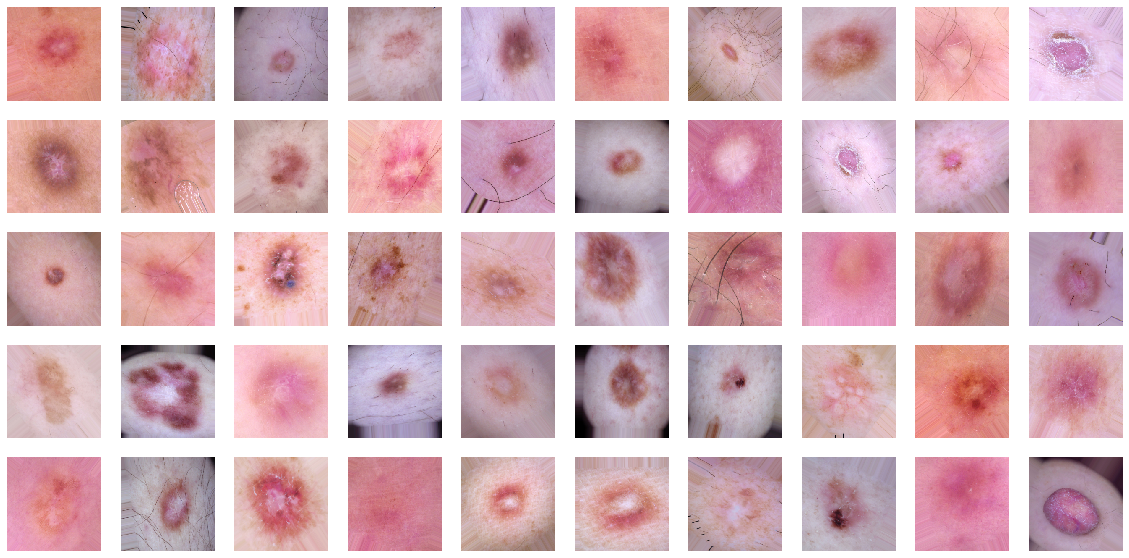

In [19]:
def plots(ims, figsize=(20,10), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

# **Set up the generators :**

In [20]:
train_path = './Base_Directory/Train_Directory'
valid_path = './Base_Directory/Validation_Directory'

num_train_samples = len(training_set)
num_val_samples = len(validation_set)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples/ train_batch_size)
val_steps = np.ceil(num_val_samples/ val_batch_size)

In [21]:
#same pre-processing that was applied to the original rgb Imagenet images that were used to train mobilenet is used to pre-process
#this data.
datagen = ImageDataGenerator(
            preprocessing_function=tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path, target_size=(image_size,image_size), batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path, target_size=(image_size,image_size), batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(valid_path, target_size=(image_size,image_size), batch_size=1, shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


# **Modifying the MobileNet model**

In [22]:
# create a copy of a mobilenet model
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [23]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [24]:
print('The number of layers MobileNet has is ', len(mobile.layers))

The number of layers MobileNet has is  93


In [25]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

# **Training the Model :**

In [27]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [28]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [29]:
#Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [30]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel   # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [31]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, class_weight=class_weights, validation_data=valid_batches,
                              validation_steps=val_steps, epochs=30, verbose=1, callbacks=callbacks_list)

Epoch 1/30
908/908 [==============================] - ETA: 0s - loss: 2.2715 - categorical_accuracy: 0.3149 - top_2_accuracy: 0.5308 - top_3_accuracy: 0.6828
Epoch 00001: val_top_3_accuracy improved from -inf to 0.86887, saving model to model.h5
908/908 [==============================] - 65s 72ms/step - loss: 2.2715 - categorical_accuracy: 0.3149 - top_2_accuracy: 0.5308 - top_3_accuracy: 0.6828 - val_loss: 1.4585 - val_categorical_accuracy: 0.4563 - val_top_2_accuracy: 0.7740 - val_top_3_accuracy: 0.8689
Epoch 2/30
908/908 [==============================] - ETA: 0s - loss: 1.7707 - categorical_accuracy: 0.4208 - top_2_accuracy: 0.6290 - top_3_accuracy: 0.7750
Epoch 00002: val_top_3_accuracy did not improve from 0.86887
908/908 [==============================] - 64s 71ms/step - loss: 1.7707 - categorical_accuracy: 0.4208 - top_2_accuracy: 0.6290 - top_3_accuracy: 0.7750 - val_loss: 13.9235 - val_categorical_accuracy: 0.0501 - val_top_2_accuracy: 0.0864 - val_top_3_accuracy: 0.1130
Epoc

Epoch 17/30
908/908 [==============================] - ETA: 0s - loss: 0.8522 - categorical_accuracy: 0.7172 - top_2_accuracy: 0.8949 - top_3_accuracy: 0.9626
Epoch 00017: val_top_3_accuracy did not improve from 0.97974
908/908 [==============================] - 65s 71ms/step - loss: 0.8522 - categorical_accuracy: 0.7172 - top_2_accuracy: 0.8949 - top_3_accuracy: 0.9626 - val_loss: 0.4048 - val_categorical_accuracy: 0.8433 - val_top_2_accuracy: 0.9371 - val_top_3_accuracy: 0.9787
Epoch 18/30
908/908 [==============================] - ETA: 0s - loss: 0.8408 - categorical_accuracy: 0.7224 - top_2_accuracy: 0.9000 - top_3_accuracy: 0.9675
Epoch 00018: val_top_3_accuracy did not improve from 0.97974

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
908/908 [==============================] - 64s 71ms/step - loss: 0.8408 - categorical_accuracy: 0.7224 - top_2_accuracy: 0.9000 - top_3_accuracy: 0.9675 - val_loss: 0.3928 - val_categorical_accuracy: 0.8529 - val_

In [32]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [33]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = model.evaluate_generator(test_batches, steps=len(validation_set))

print('val_loss:', val_loss)
print('val_categorical_accuracy:', val_cat_acc)
print('val_top_2_accuracy:', val_top_2_acc)
print('val_top_3_accutacy:', val_top_3_acc)

val_loss: 0.39597755670547485
val_categorical_accuracy: 0.8454157710075378
val_top_2_accuracy: 0.9402984976768494
val_top_3_accutacy: 0.9797441363334656


# **Plotting the training curves**

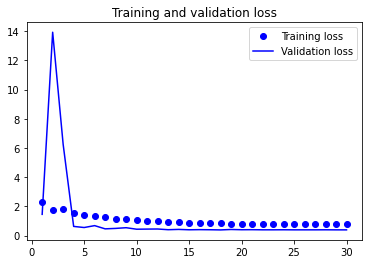

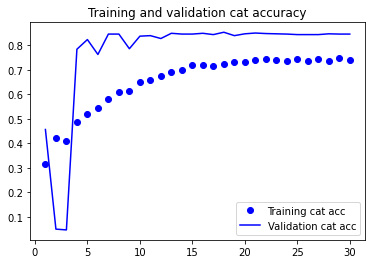

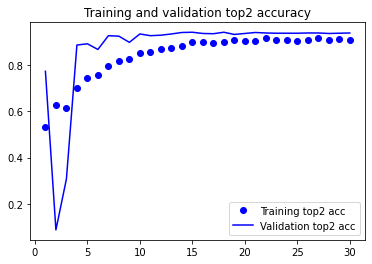

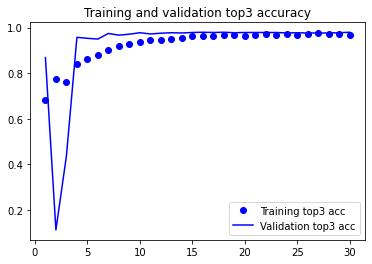

In [34]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

The validation set results are greater than training set because when training, a percentage of the features are set to zero (25% in this case as I'm using Dropout(0.25)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

# Creating a confusion matrix to analyse better :

In [35]:
test_labels = test_batches.classes
print(test_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [36]:
#making a prediction on the test batch
predictions = model.predict(test_batches, steps=len(validation_set), verbose=1)

938/938 [==============================] - 11s 12ms/step


In [37]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  8   6   2   1   6   3   0]
 [  0  20   2   0   2   5   1]
 [  0   2  27   0  19  27   0]
 [  0   0   1   1   0   4   0]
 [  0   0   6   0  20  13   0]
 [  2   3   7   1  26 711   1]
 [  0   0   0   0   0   5   6]]


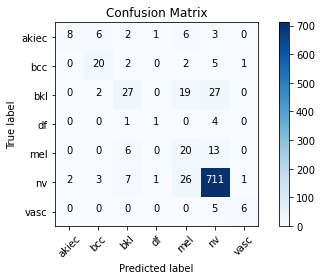

In [38]:
#plotting confusion matrix
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Classification Report

In [39]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [40]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.80      0.31      0.44        26
         bcc       0.65      0.67      0.66        30
         bkl       0.60      0.36      0.45        75
          df       0.33      0.17      0.22         6
         mel       0.27      0.51      0.36        39
          nv       0.93      0.95      0.94       751
        vasc       0.75      0.55      0.63        11

    accuracy                           0.85       938
   macro avg       0.62      0.50      0.53       938
weighted avg       0.85      0.85      0.84       938



In [41]:
# End of Model Building
### ===================================================================================== ###
# Convert the Model from Keras to Tensorflow.js

In [42]:
!pip install tensorflowjs --ignore-installed

     |████████████████████████████████| 61 kB 239 kB/s eta 0:00:011
     |████████████████████████████████| 320.4 MB 22 kB/s  eta 0:00:01    |██▌                             | 25.6 MB 1.7 MB/s eta 0:02:50     |██▋                             | 25.7 MB 1.7 MB/s eta 0:02:50     |██████▎                         | 63.2 MB 2.2 MB/s eta 0:01:57     |███████▍                        | 74.3 MB 2.1 MB/s eta 0:01:59     |████████████▉                   | 128.2 MB 4.3 MB/s eta 0:00:45     |███████████████▏                | 151.6 MB 2.1 MB/s eta 0:01:22     |█████████████████▍              | 174.0 MB 1.4 MB/s eta 0:01:44     |█████████████████▍              | 174.2 MB 2.4 MB/s eta 0:01:01     |██████████████████▏             | 181.5 MB 2.0 MB/s eta 0:01:11     |██████████████████▍             | 183.9 MB 2.0 MB/s eta 0:01:09     |████████████████████████▋       | 246.5 MB 3.3 MB/s eta 0:00:23     |█████████████████████████▏      | 252.0 MB 1.6 MB/s eta 0:00:42     |████████████████████████████▉   | 

In [43]:
import tensorflowjs as tfjs
os.mkdir('TFJS_Dir')

tfjs.converters.save_keras_model(model, 'TFJS_Dir')

/opt/conda/lib/python3.7/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [44]:
# Deleting the image data directory to prevent a Kaggle error.
shutil.rmtree(base_dir)